# 1.Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
import os
import networkx as nx
from collections import defaultdict

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

# 2. Load and Analyze Rotation Rules

In [4]:
rotation_file="../data/raw/rotation_rules.csv"

In [5]:
try:
    rotation_df=pd.read_csv(rotation_file)
    print(f"Loaded rotation_rules.csv: {len(rotation_df)} rotation combinations")
except FileNotFoundError:
    print(f"Error: {rotation_file} not found. Please check the file path.")
    rotation_df=None

Loaded rotation_rules.csv: 342 rotation combinations


In [6]:
if rotation_df is not None:
    print(f"Dataset Shape: {rotation_df.shape}")
    print(f"Columns: {rotation_df.columns.tolist()}")
    print(f"Data Types:")
    print(rotation_df.dtypes)
    print(f"First 10 rows:")
    print(rotation_df.head(10))

Dataset Shape: (342, 6)
Columns: ['Crop1', 'Crop2', 'Season1', 'Season2', 'Compatibility_Score', 'Soil_Impact']
Data Types:
Crop1                   object
Crop2                   object
Season1                 object
Season2                 object
Compatibility_Score    float64
Soil_Impact             object
dtype: object
First 10 rows:
  Crop1      Crop2 Season1 Season2  Compatibility_Score Soil_Impact
0  Rice      Maize  Kharif  Kharif                 0.60    Negative
1  Rice    Sorghum  Kharif  Kharif                 0.70     Neutral
2  Rice      Bajra  Kharif  Kharif                 0.70     Neutral
3  Rice    Soybean  Kharif  Kharif                 0.85    Positive
4  Rice     Cotton  Kharif  Kharif                 0.70     Neutral
5  Rice  Groundnut  Kharif  Kharif                 0.75     Neutral
6  Rice     Sesame  Kharif  Kharif                 0.70     Neutral
7  Rice      Wheat  Kharif    Rabi                 0.60    Negative
8  Rice     Barley  Kharif    Rabi               

Exploratory Analysis Of Rotation Data

In [7]:
all_crops=set(rotation_df['Crop1'].unique()) | set(rotation_df['Crop2'].unique())
print(f"Total unique crops in rotation database: {len(all_crops)}")
print(f"Crops:{sorted(all_crops)}")

Total unique crops in rotation database: 19
Crops:['Bajra', 'Barley', 'Chickpea', 'Cotton', 'Cucumber', 'Groundnut', 'Lentil', 'Linseed', 'Maize', 'Mung Bean', 'Mustard', 'Pea', 'Pumpkin', 'Rice', 'Sesame', 'Sorghum', 'Soybean', 'Watermelon', 'Wheat']


In [8]:
seasons=set(rotation_df['Season1'].unique()) | set(rotation_df['Season2'].unique())
print(f"Seasons:{sorted(seasons)}")

Seasons:['Kharif', 'Rabi', 'Zaid']


In [9]:
print("\nCompatibility Score Statistics:")
print(rotation_df['Compatibility_Score'].describe())


Compatibility Score Statistics:
count    342.000000
mean       0.716667
std        0.049038
min        0.600000
25%        0.700000
50%        0.700000
75%        0.700000
max        0.850000
Name: Compatibility_Score, dtype: float64


In [10]:
print("Soil Impact Distribution:")
print(rotation_df['Soil_Impact'].value_counts())

Soil Impact Distribution:
Soil_Impact
Neutral     300
Positive     30
Negative     12
Name: count, dtype: int64


In [11]:
crop_seasons = rotation_df.groupby('Crop1')['Season1'].first().reset_index()
for season in ['Kharif', 'Rabi', 'Zaid']:
    crops_in_season = crop_seasons[crop_seasons['Season1'] == season]['Crop1'].tolist()
    print(f"{season}:{', '.join(crops_in_season)}")

Kharif:Bajra, Cotton, Groundnut, Maize, Rice, Sesame, Sorghum, Soybean
Rabi:Barley, Chickpea, Lentil, Linseed, Mustard, Pea, Wheat
Zaid:Cucumber, Mung Bean, Pumpkin, Watermelon


Data Preprocessing and Enhancing Data

In [12]:
rotation_df["Crop1"]=rotation_df["Crop1"].str.lower().str.strip()
rotation_df["Crop2"]=rotation_df["Crop2"].str.lower().str.strip()

In [13]:
crop_categories = {
    'rice': 'Cereal',
    'maize': 'Cereal',
    'wheat': 'Cereal',
    'barley': 'Cereal',
    'sorghum': 'Cereal',
    'bajra': 'Cereal',
    
    'chickpea': 'Legume',
    'lentil': 'Legume',
    'pea': 'Legume',
    'mung bean': 'Legume',
    'pigeonpeas': 'Legume',
    'blackgram': 'Legume',
    'kidneybeans': 'Legume',
    'mothbeans': 'Legume',
    
    'soybean': 'Oilseed',
    'groundnut': 'Oilseed',
    'mustard': 'Oilseed',
    'sesame': 'Oilseed',
    'linseed': 'Oilseed',
    
    'cotton': 'Fibre',
    'jute': 'Fibre',
    
    'pumpkin': 'Vegetable',
    'cucumber': 'Vegetable',
    'watermelon': 'Vegetable',
    'muskmelon': 'Vegetable',
    
    
    'banana': 'Fruit',
    'mango': 'Fruit',
    'apple': 'Fruit',
    'orange': 'Fruit',
    'grapes': 'Fruit',
    'pomegranate': 'Fruit',
    'papaya': 'Fruit',
    'coconut': 'Fruit',
    
    'coffee': 'Plantation'
}

In [14]:
nitrogen_impact = {
    'Legume': +15,     
    'Cereal': -20,      
    'Oilseed': -5,      
    'Fibre': -10,       
    'Vegetable': -8,    
    'Fruit': -3,        
    'Plantation': -2    
}

In [15]:
rotation_df['Category1'] = rotation_df['Crop1'].map(crop_categories).fillna('Unknown')
rotation_df['Category2'] = rotation_df['Crop2'].map(crop_categories).fillna('Unknown')

In [16]:
soil_impact_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
rotation_df['Soil_Impact_Numeric'] = rotation_df['Soil_Impact'].map(soil_impact_map)

In [17]:
print(rotation_df.head(10))

  Crop1      Crop2 Season1 Season2  Compatibility_Score Soil_Impact Category1  \
0  rice      maize  Kharif  Kharif                 0.60    Negative    Cereal   
1  rice    sorghum  Kharif  Kharif                 0.70     Neutral    Cereal   
2  rice      bajra  Kharif  Kharif                 0.70     Neutral    Cereal   
3  rice    soybean  Kharif  Kharif                 0.85    Positive    Cereal   
4  rice     cotton  Kharif  Kharif                 0.70     Neutral    Cereal   
5  rice  groundnut  Kharif  Kharif                 0.75     Neutral    Cereal   
6  rice     sesame  Kharif  Kharif                 0.70     Neutral    Cereal   
7  rice      wheat  Kharif    Rabi                 0.60    Negative    Cereal   
8  rice     barley  Kharif    Rabi                 0.60    Negative    Cereal   
9  rice    mustard  Kharif    Rabi                 0.75     Neutral    Cereal   

  Category2  Soil_Impact_Numeric  
0    Cereal                   -1  
1    Cereal                    0  
2  

# Define Crop and Season Data

In [18]:
season_calendar = {
    'Kharif': {'start': 'June', 'end': 'October', 'months': [6, 7, 8, 9, 10]},
    'Rabi': {'start': 'November', 'end': 'March', 'months': [11, 12, 1, 2, 3]},
    'Zaid': {'start': 'March', 'end': 'June', 'months': [3, 4, 5, 6]}
}

In [19]:
season_sequence = ['Kharif', 'Rabi', 'Zaid']

In [20]:
crop_nutrient_data = {
    'rice': {'N_requirement': 'High', 'N_effect': -25, 'P_effect': -15, 'K_effect': -20, 'water': 'High'},
    'wheat': {'N_requirement': 'High', 'N_effect': -20, 'P_effect': -12, 'K_effect': -15, 'water': 'Medium'},
    'maize': {'N_requirement': 'High', 'N_effect': -22, 'P_effect': -10, 'K_effect': -18, 'water': 'Medium'},
    'chickpea': {'N_requirement': 'Low', 'N_effect': +20, 'P_effect': -8, 'K_effect': -10, 'water': 'Low'},
    'lentil': {'N_requirement': 'Low', 'N_effect': +18, 'P_effect': -6, 'K_effect': -8, 'water': 'Low'},
    'mung bean': {'N_requirement': 'Low', 'N_effect': +15, 'P_effect': -5, 'K_effect': -6, 'water': 'Low'},
    'pea': {'N_requirement': 'Low', 'N_effect': +12, 'P_effect': -5, 'K_effect': -5, 'water': 'Low'},
    'soybean': {'N_requirement': 'Low', 'N_effect': +10, 'P_effect': -8, 'K_effect': -10, 'water': 'Medium'},
    'groundnut': {'N_requirement': 'Low', 'N_effect': +8, 'P_effect': -10, 'K_effect': -8, 'water': 'Medium'},
    'mustard': {'N_requirement': 'Medium', 'N_effect': -10, 'P_effect': -8, 'K_effect': -5, 'water': 'Low'},
    'cotton': {'N_requirement': 'High', 'N_effect': -18, 'P_effect': -15, 'K_effect': -20, 'water': 'Medium'},
    'sorghum': {'N_requirement': 'Medium', 'N_effect': -15, 'P_effect': -8, 'K_effect': -12, 'water': 'Low'},
    'bajra': {'N_requirement': 'Low', 'N_effect': -12, 'P_effect': -6, 'K_effect': -10, 'water': 'Low'},
    'barley': {'N_requirement': 'Medium', 'N_effect': -15, 'P_effect': -10, 'K_effect': -12, 'water': 'Low'},
    'sesame': {'N_requirement': 'Low', 'N_effect': -8, 'P_effect': -5, 'K_effect': -6, 'water': 'Low'},
    'linseed': {'N_requirement': 'Medium', 'N_effect': -10, 'P_effect': -8, 'K_effect': -8, 'water': 'Low'},
    'watermelon': {'N_requirement': 'Medium', 'N_effect': -12, 'P_effect': -10, 'K_effect': -15, 'water': 'High'},
    'pumpkin': {'N_requirement': 'Medium', 'N_effect': -10, 'P_effect': -8, 'K_effect': -12, 'water': 'Medium'},
    'cucumber': {'N_requirement': 'Medium', 'N_effect': -10, 'P_effect': -8, 'K_effect': -12, 'water': 'High'},
    'jute': {'N_requirement': 'Medium', 'N_effect': -12, 'P_effect': -8, 'K_effect': -10, 'water': 'High'}
}

In [21]:
default_nutrient = {'N_requirement': 'Medium', 'N_effect': -10, 'P_effect': -8, 'K_effect': -10, 'water': 'Medium'}

In [22]:
print("Crop and season parameters defined!")
print("Season Calendar:")
for season,info in season_calendar.items():
    print(f"{season}:{info['start']} - {info['end']}")

Crop and season parameters defined!
Season Calendar:
Kharif:June - October
Rabi:November - March
Zaid:March - June


In [23]:
print("Nitrogen Impact by Crop Category:")
for cat, impact in nitrogen_impact.items():
    sign='+' if impact > 0 else ''
    print(f"{cat}: {sign}{impact} kg/ha")

Nitrogen Impact by Crop Category:
Legume: +15 kg/ha
Cereal: -20 kg/ha
Oilseed: -5 kg/ha
Fibre: -10 kg/ha
Vegetable: -8 kg/ha
Fruit: -3 kg/ha
Plantation: -2 kg/ha


In [24]:
class CropRotationPlanner:
    """
    Comprehensive Crop Rotation Planning System
    
    Features:
    - Rule-based rotation recommendations
    - Soil nutrient tracking
    - Sustainability scoring
    - Multi-season planning
    - Economic integration
    """
    
    def __init__(self, rotation_rules_df, crop_categories, crop_nutrient_data, 
                 nitrogen_impact, season_sequence):
        """
        Initialize the rotation planner
        
        Parameters:
        -----------
        rotation_rules_df : pd.DataFrame
            Rotation rules with compatibility scores
        crop_categories : dict
            Mapping of crops to categories
        crop_nutrient_data : dict
            Nutrient requirements and effects for each crop
        nitrogen_impact : dict
            Nitrogen impact by crop category
        season_sequence : list
            Order of seasons
        """
        self.rotation_rules = rotation_rules_df.copy()
        self.crop_categories = crop_categories
        self.crop_nutrient_data = crop_nutrient_data
        self.nitrogen_impact = nitrogen_impact
        self.season_sequence = season_sequence
        self.default_nutrient = {'N_requirement': 'Medium', 'N_effect': -10, 
                                  'P_effect': -8, 'K_effect': -10, 'water': 'Medium'}
        
        # Build lookup dictionaries for faster access
        self._build_rotation_lookup()
        
        print("Crop Rotation Planner initialized!")
    
    def _build_rotation_lookup(self):
        """Build efficient lookup structures"""
        self.rotation_lookup = defaultdict(list)
        
        for _, row in self.rotation_rules.iterrows():
            crop1 = row['Crop1'].lower()
            crop2 = row['Crop2'].lower()
            
            self.rotation_lookup[crop1].append({
                'next_crop': crop2,
                'from_season': row['Season1'],
                'to_season': row['Season2'],
                'compatibility': row['Compatibility_Score'],
                'soil_impact': row['Soil_Impact']
            })
    
    def get_crop_category(self, crop):
        """Get category for a crop"""
        return self.crop_categories.get(crop.lower(), 'Unknown')
    
    def get_crop_nutrient_info(self, crop):
        """Get nutrient information for a crop"""
        return self.crop_nutrient_data.get(crop.lower(), self.default_nutrient)
    
    def get_next_season(self, current_season):
        """Get the next season in the cycle"""
        idx = self.season_sequence.index(current_season)
        next_idx = (idx + 1) % len(self.season_sequence)
        return self.season_sequence[next_idx]
    
    def filter_by_compatibility(self, current_crop, min_compatibility=0.6):
        """
        Filter crops by compatibility with current crop
        
        Parameters:
        -----------
        current_crop : str
            Current crop name
        min_compatibility : float
            Minimum compatibility score (default: 0.6)
            
        Returns:
        --------
        list : List of compatible crops with details
        """
        current_crop = current_crop.lower()
        compatible_crops = []
        
        for rotation in self.rotation_lookup.get(current_crop, []):
            if rotation['compatibility'] >= min_compatibility:
                compatible_crops.append(rotation)
        
        # Sort by compatibility (descending)
        compatible_crops.sort(key=lambda x: x['compatibility'], reverse=True)
        
        return compatible_crops
    
    def filter_by_season(self, compatible_crops, target_season):
        """Filter compatible crops by target season"""
        return [c for c in compatible_crops if c['to_season'] == target_season]
    
    def filter_by_soil_impact(self, compatible_crops, prefer_positive=True):
        """Filter or sort by soil impact preference"""
        if prefer_positive:
            # Prioritize positive, then neutral, then negative
            priority = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
            return sorted(compatible_crops, key=lambda x: priority.get(x['soil_impact'], 1))
        return compatible_crops
    
    def select_best_rotation(self, compatible_crops, target_season=None, 
                             prefer_positive_soil=True, top_n=3):
        """
        Select the best rotation options
        
        Parameters:
        -----------
        compatible_crops : list
            List of compatible crop options
        target_season : str, optional
            Filter by specific season
        prefer_positive_soil : bool
            Prefer positive soil impact crops
        top_n : int
            Number of top recommendations
            
        Returns:
        --------
        list : Top N best rotation options
        """
        crops = compatible_crops.copy()
        
        # Filter by season if specified
        if target_season:
            crops = self.filter_by_season(crops, target_season)
        
        # Sort by soil impact preference
        if prefer_positive_soil:
            crops = self.filter_by_soil_impact(crops, prefer_positive=True)
        
        return crops[:top_n]
    
    def calculate_soil_nutrients(self, crop_sequence):
        """
        Track soil nutrient changes over a crop sequence
        
        Parameters:
        -----------
        crop_sequence : list
            List of crops in rotation order
            
        Returns:
        --------
        dict : Nutrient tracking data
        """
        # Initial soil nutrients (assumed starting point)
        nutrients = {'N': 100, 'P': 100, 'K': 100}
        history = [{'crop': 'Initial', 'N': 100, 'P': 100, 'K': 100}]
        
        for crop in crop_sequence:
            crop = crop.lower()
            nutrient_info = self.get_crop_nutrient_info(crop)
            
            # Update nutrients
            nutrients['N'] = max(0, min(150, nutrients['N'] + nutrient_info['N_effect']))
            nutrients['P'] = max(0, min(150, nutrients['P'] + nutrient_info['P_effect']))
            nutrients['K'] = max(0, min(150, nutrients['K'] + nutrient_info['K_effect']))
            
            history.append({
                'crop': crop,
                'N': round(nutrients['N'], 1),
                'P': round(nutrients['P'], 1),
                'K': round(nutrients['K'], 1)
            })
        
        return {
            'final_nutrients': nutrients,
            'history': history,
            'n_balance': nutrients['N'] - 100,
            'p_balance': nutrients['P'] - 100,
            'k_balance': nutrients['K'] - 100
        }
    
    def calculate_sustainability_score(self, crop_sequence):
        """
        Calculate sustainability score for a crop rotation plan
        
        Score components:
        - Diversity score (25%): Variety of crop categories
        - Soil health score (30%): Nutrient balance
        - Compatibility score (25%): Average rotation compatibility
        - Legume inclusion (20%): Nitrogen-fixing crops included
        
        Parameters:
        -----------
        crop_sequence : list
            List of crops in rotation order
            
        Returns:
        --------
        dict : Sustainability scores and rating
        """
        if len(crop_sequence) < 2:
            return {'total_score': 0, 'rating': 'Insufficient data'}
        
        # 1. Diversity Score (25%)
        categories = [self.get_crop_category(c) for c in crop_sequence]
        unique_categories = len(set(categories))
        diversity_score = min(unique_categories / 3 * 100, 100) * 0.25
        
        # 2. Soil Health Score (30%)
        nutrients = self.calculate_soil_nutrients(crop_sequence)
        n_balance = nutrients['n_balance']
        
        # Ideal: slight positive nitrogen balance
        if -10 <= n_balance <= 20:
            soil_score = 100
        elif -20 <= n_balance <= 30:
            soil_score = 75
        elif -30 <= n_balance <= 40:
            soil_score = 50
        else:
            soil_score = 25
        soil_health_score = soil_score * 0.30
        
        # 3. Compatibility Score (25%)
        total_compatibility = 0
        count = 0
        
        for i in range(len(crop_sequence) - 1):
            crop1 = crop_sequence[i].lower()
            crop2 = crop_sequence[i + 1].lower()
            
            # Find compatibility
            for rotation in self.rotation_lookup.get(crop1, []):
                if rotation['next_crop'] == crop2:
                    total_compatibility += rotation['compatibility']
                    count += 1
                    break
        
        avg_compatibility = (total_compatibility / count * 100) if count > 0 else 50
        compatibility_score = avg_compatibility * 0.25
        
        # 4. Legume Inclusion (20%)
        legume_count = sum(1 for c in crop_sequence if self.get_crop_category(c) == 'Legume')
        legume_ratio = legume_count / len(crop_sequence)
        
        if legume_ratio >= 0.33:
            legume_score = 100
        elif legume_ratio >= 0.25:
            legume_score = 80
        elif legume_ratio > 0:
            legume_score = 60
        else:
            legume_score = 30
        legume_inclusion_score = legume_score * 0.20
        
        # Total score
        total_score = diversity_score + soil_health_score + compatibility_score + legume_inclusion_score
        
        # Rating
        if total_score >= 80:
            rating = 'Excellent'
        elif total_score >= 60:
            rating = 'Good'
        elif total_score >= 40:
            rating = 'Fair'
        else:
            rating = 'Poor'
        
        return {
            'total_score': round(total_score, 1),
            'rating': rating,
            'components': {
                'diversity': round(diversity_score / 0.25, 1),
                'soil_health': round(soil_health_score / 0.30, 1),
                'compatibility': round(compatibility_score / 0.25, 1),
                'legume_inclusion': round(legume_inclusion_score / 0.20, 1)
            },
            'details': {
                'unique_categories': unique_categories,
                'legume_count': legume_count,
                'n_balance': n_balance
            }
        }
    
    def get_rotation_plan(self, current_crop, current_season, num_seasons=3,
                          min_compatibility=0.7, prefer_positive_soil=True):
        """
        Generate a multi-season rotation plan
        
        Parameters:
        -----------
        current_crop : str
            Current crop name
        current_season : str
            Current season (Kharif, Rabi, Zaid)
        num_seasons : int
            Number of seasons to plan (default: 3)
        min_compatibility : float
            Minimum compatibility score
        prefer_positive_soil : bool
            Prefer crops with positive soil impact
            
        Returns:
        --------
        dict : Complete rotation plan with recommendations
        """
        current_crop = current_crop.lower()
        plan = []
        
        # Season 1: Current crop
        plan.append({
            'season_num': 1,
            'season': current_season,
            'crop': current_crop,
            'category': self.get_crop_category(current_crop),
            'reason': 'Current crop'
        })
        
        prev_crop = current_crop
        prev_season = current_season
        
        for i in range(2, num_seasons + 1):
            next_season = self.get_next_season(prev_season)
            
            # Get compatible crops
            compatible = self.filter_by_compatibility(prev_crop, min_compatibility)
            
            # Filter by next season
            season_filtered = self.filter_by_season(compatible, next_season)
            
            # If no crops for specific season, get best available
            if not season_filtered:
                season_filtered = compatible[:5]  # Top 5 regardless of season
            
            # Sort by soil impact
            if prefer_positive_soil:
                season_filtered = self.filter_by_soil_impact(season_filtered)
            
            if season_filtered:
                best_choice = season_filtered[0]
                
                # Determine reason
                category = self.get_crop_category(best_choice['next_crop'])
                if best_choice['soil_impact'] == 'Positive':
                    reason = f"Soil improvement ({category})"
                elif category == 'Legume':
                    reason = "Nitrogen fixation (Legume)"
                else:
                    reason = f"Good compatibility ({best_choice['compatibility']:.0%})"
                
                plan.append({
                    'season_num': i,
                    'season': next_season,
                    'crop': best_choice['next_crop'],
                    'category': category,
                    'compatibility': best_choice['compatibility'],
                    'soil_impact': best_choice['soil_impact'],
                    'reason': reason
                })
                
                prev_crop = best_choice['next_crop']
            else:
                # No compatible crop found
                plan.append({
                    'season_num': i,
                    'season': next_season,
                    'crop': 'No recommendation',
                    'category': 'N/A',
                    'reason': 'No compatible crop found'
                })
            
            prev_season = next_season
        
        # Calculate sustainability
        crop_sequence = [p['crop'] for p in plan if p['crop'] != 'No recommendation']
        sustainability = self.calculate_sustainability_score(crop_sequence)
        nutrients = self.calculate_soil_nutrients(crop_sequence)
        
        return {
            'plan': plan,
            'sustainability': sustainability,
            'nutrients': nutrients,
            'summary': {
                'starting_crop': current_crop,
                'starting_season': current_season,
                'num_seasons': num_seasons,
                'overall_score': sustainability['total_score'],
                'rating': sustainability['rating']
            }
        }
    
    def get_alternative_plans(self, current_crop, current_season, num_alternatives=3):
        """
        Generate multiple alternative rotation plans
        
        Parameters:
        -----------
        current_crop : str
            Current crop
        current_season : str
            Current season
        num_alternatives : int
            Number of alternative plans to generate
            
        Returns:
        --------
        list : List of alternative rotation plans
        """
        alternatives = []
        
        # Get all compatible crops for season 2
        compatible = self.filter_by_compatibility(current_crop.lower(), 0.6)
        next_season = self.get_next_season(current_season)
        season_filtered = self.filter_by_season(compatible, next_season)[:num_alternatives * 2]
        
        for i, rotation in enumerate(season_filtered[:num_alternatives]):
            # Create a plan starting with this alternative
            alt_plan = self.get_rotation_plan(
                current_crop, current_season, 
                num_seasons=3,
                min_compatibility=0.65
            )
            
            # Modify season 2 with the alternative
            if len(alt_plan['plan']) > 1:
                alt_plan['plan'][1]['crop'] = rotation['next_crop']
                alt_plan['plan'][1]['category'] = self.get_crop_category(rotation['next_crop'])
                alt_plan['plan'][1]['compatibility'] = rotation['compatibility']
                alt_plan['plan'][1]['soil_impact'] = rotation['soil_impact']
            
            # Recalculate sustainability
            crop_sequence = [p['crop'] for p in alt_plan['plan']]
            alt_plan['sustainability'] = self.calculate_sustainability_score(crop_sequence)
            alt_plan['nutrients'] = self.calculate_soil_nutrients(crop_sequence)
            alt_plan['alternative_num'] = i + 1
            
            alternatives.append(alt_plan)
        
        # Sort by sustainability score
        alternatives.sort(key=lambda x: x['sustainability']['total_score'], reverse=True)
        
        return alternatives
    
    def get_best_successor(self, current_crop, target_season=None):
        """
        Get the single best successor crop
        
        Parameters:
        -----------
        current_crop : str
            Current crop
        target_season : str, optional
            Target season for next crop
            
        Returns:
        --------
        dict : Best successor crop details
        """
        current_crop = current_crop.lower()
        compatible = self.filter_by_compatibility(current_crop, 0.7)
        
        if target_season:
            compatible = self.filter_by_season(compatible, target_season)
        
        # Prioritize positive soil impact
        compatible = self.filter_by_soil_impact(compatible, prefer_positive=True)
        
        if compatible:
            best = compatible[0]
            return {
                'success': True,
                'next_crop': best['next_crop'],
                'to_season': best['to_season'],
                'compatibility': best['compatibility'],
                'soil_impact': best['soil_impact'],
                'category': self.get_crop_category(best['next_crop'])
            }
        else:
            return {
                'success': False,
                'error': f"No compatible successor found for {current_crop}"
            }
    
    def generate_rotation_report(self, rotation_plan):
       
        plan = rotation_plan['plan']
        sustainability = rotation_plan['sustainability']
        nutrients = rotation_plan['nutrients']
        
        report = f"""

ROTATION SEQUENCE
"""
        
        for p in plan:
            season_label = f"Season {p['season_num']}"
            report += f"""
   {season_label} ({p['season']}): {p['crop'].upper()}
      Category: {p['category']}
      Reason: {p['reason']}
"""
            if 'compatibility' in p:
                report += f"      Compatibility: {p['compatibility']:.0%} | Soil Impact: {p['soil_impact']}\n"
        
        report += f"""
SUSTAINABILITY ASSESSMENT
   Overall Score: {sustainability['total_score']}/100
   Rating: {sustainability['rating']}
   
   Component Scores:
   Crop Diversity:      {sustainability['components']['diversity']}/100
   Soil Health:         {sustainability['components']['soil_health']}/100
   Compatibility:       {sustainability['components']['compatibility']}/100
   Legume Inclusion:    {sustainability['components']['legume_inclusion']}/100

SOIL NUTRIENT TRACKING
   Nitrogen Balance: {nutrients['n_balance']:+.1f} kg/ha
   Phosphorus Balance: {nutrients['p_balance']:+.1f} kg/ha
   Potassium Balance: {nutrients['k_balance']:+.1f} kg/ha
   
   Final Nutrient Levels:
   ├── Nitrogen (N):   {nutrients['final_nutrients']['N']:.1f}%
   ├── Phosphorus (P): {nutrients['final_nutrients']['P']:.1f}%
   └── Potassium (K):  {nutrients['final_nutrients']['K']:.1f}%

RECOMMENDATIONS
"""
        
        # Add specific recommendations based on analysis
        if sustainability['total_score'] >= 80:
            report += "   Excellent rotation plan! Continue with this sequence.\n"
        elif sustainability['total_score'] >= 60:
            report += "  Good rotation plan with room for improvement.\n"
        else:
            report += "  Not optimal. Consider adding more legumes or diversifying crops.\n"
        
        if nutrients['n_balance'] < -15:
            report += "   Not optimal. Consider adding nitrogen-fixing crops (legumes) to improve N balance.\n"
        elif nutrients['n_balance'] > 10:
            report += "Good nitrogen balance due to legume inclusion.\n"
        
        report += """
"""
        return report


# Initialize the planner
print("\nInitializing Crop Rotation Planner...")

rotation_planner = CropRotationPlanner(
    rotation_rules_df=rotation_df,
    crop_categories=crop_categories,
    crop_nutrient_data=crop_nutrient_data,
    nitrogen_impact=nitrogen_impact,
    season_sequence=season_sequence
)

print("Crop Rotation Planner ready!")


Initializing Crop Rotation Planner...
Crop Rotation Planner initialized!
Crop Rotation Planner ready!


In [25]:
rice_plan = rotation_planner.get_rotation_plan(
    current_crop='rice',
    current_season='Kharif',
    num_seasons=3,
    min_compatibility=0.7
)

In [26]:
for p in rice_plan['plan']:
    print(f"\nSeason {p['season_num']} ({p['season']}): {p['crop'].upper()}")
    print(f"Category: {p['category']}")
    print(f"Reason: {p['reason']}")
    if 'compatibility' in p:
        print(f"Compatibility: {p['compatibility']:.0%}")
        print(f"Soil Impact: {p['soil_impact']}")

print(f"\nSustainability Score: {rice_plan['sustainability']['total_score']}/100")
print(f"Rating: {rice_plan['sustainability']['rating']}")


Season 1 (Kharif): RICE
Category: Cereal
Reason: Current crop

Season 2 (Rabi): CHICKPEA
Category: Legume
Reason: Soil improvement (Legume)
Compatibility: 85%
Soil Impact: Positive

Season 3 (Zaid): MUNG BEAN
Category: Legume
Reason: Nitrogen fixation (Legume)
Compatibility: 70%
Soil Impact: Neutral

Sustainability Score: 86.0/100
Rating: Excellent


In [27]:

print("TEST 2: Rotation Plan for WHEAT (Rabi)")

wheat_plan = rotation_planner.get_rotation_plan(
    current_crop='wheat',
    current_season='Rabi',
    num_seasons=3
)

for p in wheat_plan['plan']:
    print(f"\nSeason {p['season_num']} ({p['season']}): {p['crop'].upper()}")
    print(f"Category: {p['category']}")

print(f"\nSustainability Score: {wheat_plan['sustainability']['total_score']}/100")
print(f"\nNutrient Changes:")
print(f"N: {wheat_plan['nutrients']['n_balance']:+.1f}")
print(f"P: {wheat_plan['nutrients']['p_balance']:+.1f}")
print(f"K: {wheat_plan['nutrients']['k_balance']:+.1f}")

TEST 2: Rotation Plan for WHEAT (Rabi)

Season 1 (Rabi): WHEAT
Category: Cereal

Season 2 (Zaid): MUNG BEAN
Category: Legume

Season 3 (Kharif): SOYBEAN
Category: Oilseed

Sustainability Score: 95.0/100

Nutrient Changes:
N: +5.0
P: -25.0
K: -31.0


In [28]:
# Test 3: Get alternative plans
print("\n" + "-" * 80)
print("📋 TEST 3: Alternative Plans for COTTON (Kharif)")
print("-" * 60)

cotton_alternatives = rotation_planner.get_alternative_plans(
    current_crop='cotton',
    current_season='Kharif',
    num_alternatives=3
)

for i, alt in enumerate(cotton_alternatives, 1):
    crops = [p['crop'] for p in alt['plan']]
    score = alt['sustainability']['total_score']
    print(f"\n   Alternative {i}: {' → '.join(crops)}")
    print(f"      Sustainability Score: {score}/100 ({alt['sustainability']['rating']})")


--------------------------------------------------------------------------------
📋 TEST 3: Alternative Plans for COTTON (Kharif)
------------------------------------------------------------

   Alternative 1: cotton → barley → mung bean
      Sustainability Score: 86.9/100 (Excellent)

   Alternative 2: cotton → mustard → mung bean
      Sustainability Score: 85.6/100 (Excellent)

   Alternative 3: cotton → wheat → mung bean
      Sustainability Score: 79.4/100 (Good)


In [29]:
print("TEST 4: Best Successor Crops")

test_crops = ['rice', 'wheat', 'maize', 'chickpea', 'cotton']

for crop in test_crops:
    successor = rotation_planner.get_best_successor(crop)
    if successor['success']:
        print(f"\n{crop.upper()} → {successor['next_crop'].upper()}")
        print(f"Season: {successor['to_season']}")
        print(f"Compatibility: {successor['compatibility']:.0%}")
        print(f"Soil Impact: {successor['soil_impact']}")
        print(f"Category: {successor['category']}")

TEST 4: Best Successor Crops

RICE → SOYBEAN
Season: Kharif
Compatibility: 85%
Soil Impact: Positive
Category: Oilseed

WHEAT → SOYBEAN
Season: Kharif
Compatibility: 85%
Soil Impact: Positive
Category: Oilseed

MAIZE → SOYBEAN
Season: Kharif
Compatibility: 85%
Soil Impact: Positive
Category: Oilseed

CHICKPEA → SOYBEAN
Season: Kharif
Compatibility: 75%
Soil Impact: Neutral
Category: Oilseed

COTTON → SOYBEAN
Season: Kharif
Compatibility: 75%
Soil Impact: Neutral
Category: Oilseed


In [30]:
print("TEST 5: Detailed Rotation Report")

maize_plan = rotation_planner.get_rotation_plan(
    current_crop='maize',
    current_season='Kharif',
    num_seasons=4
)

report = rotation_planner.generate_rotation_report(maize_plan)
print(report)

TEST 5: Detailed Rotation Report


ROTATION SEQUENCE

   Season 1 (Kharif): MAIZE
      Category: Cereal
      Reason: Current crop

   Season 2 (Rabi): CHICKPEA
      Category: Legume
      Reason: Soil improvement (Legume)
      Compatibility: 85% | Soil Impact: Positive

   Season 3 (Zaid): MUNG BEAN
      Category: Legume
      Reason: Nitrogen fixation (Legume)
      Compatibility: 70% | Soil Impact: Neutral

   Season 4 (Kharif): SOYBEAN
      Category: Oilseed
      Reason: Good compatibility (75%)
      Compatibility: 75% | Soil Impact: Neutral

SUSTAINABILITY ASSESSMENT
   Overall Score: 86.7/100
   Rating: Excellent

   Component Scores:
   Crop Diversity:      100.0/100
   Soil Health:         75.0/100
   Compatibility:       76.7/100
   Legume Inclusion:    100.0/100

SOIL NUTRIENT TRACKING
   Nitrogen Balance: +23.0 kg/ha
   Phosphorus Balance: -31.0 kg/ha
   Potassium Balance: -44.0 kg/ha

   Final Nutrient Levels:
   ├── Nitrogen (N):   123.0%
   ├── Phosphorus (P): 69.0

Visualization

In [31]:
def create_rotation_network(rotation_df, min_compatibility=0.7):
    filtered_df=rotation_df[rotation_df['Compatibility_Score'] >= min_compatibility]
    
    G=nx.DiGraph()
    
    for _,row in filtered_df.iterrows():
        G.add_edge(row["Crop1"],row["Crop2"],
                   weight=row["Compatibility_Score"],
                   soil_impact=row["Soil_Impact"]
                   )
    return G

G=create_rotation_network(rotation_df, min_compatibility=0.75)

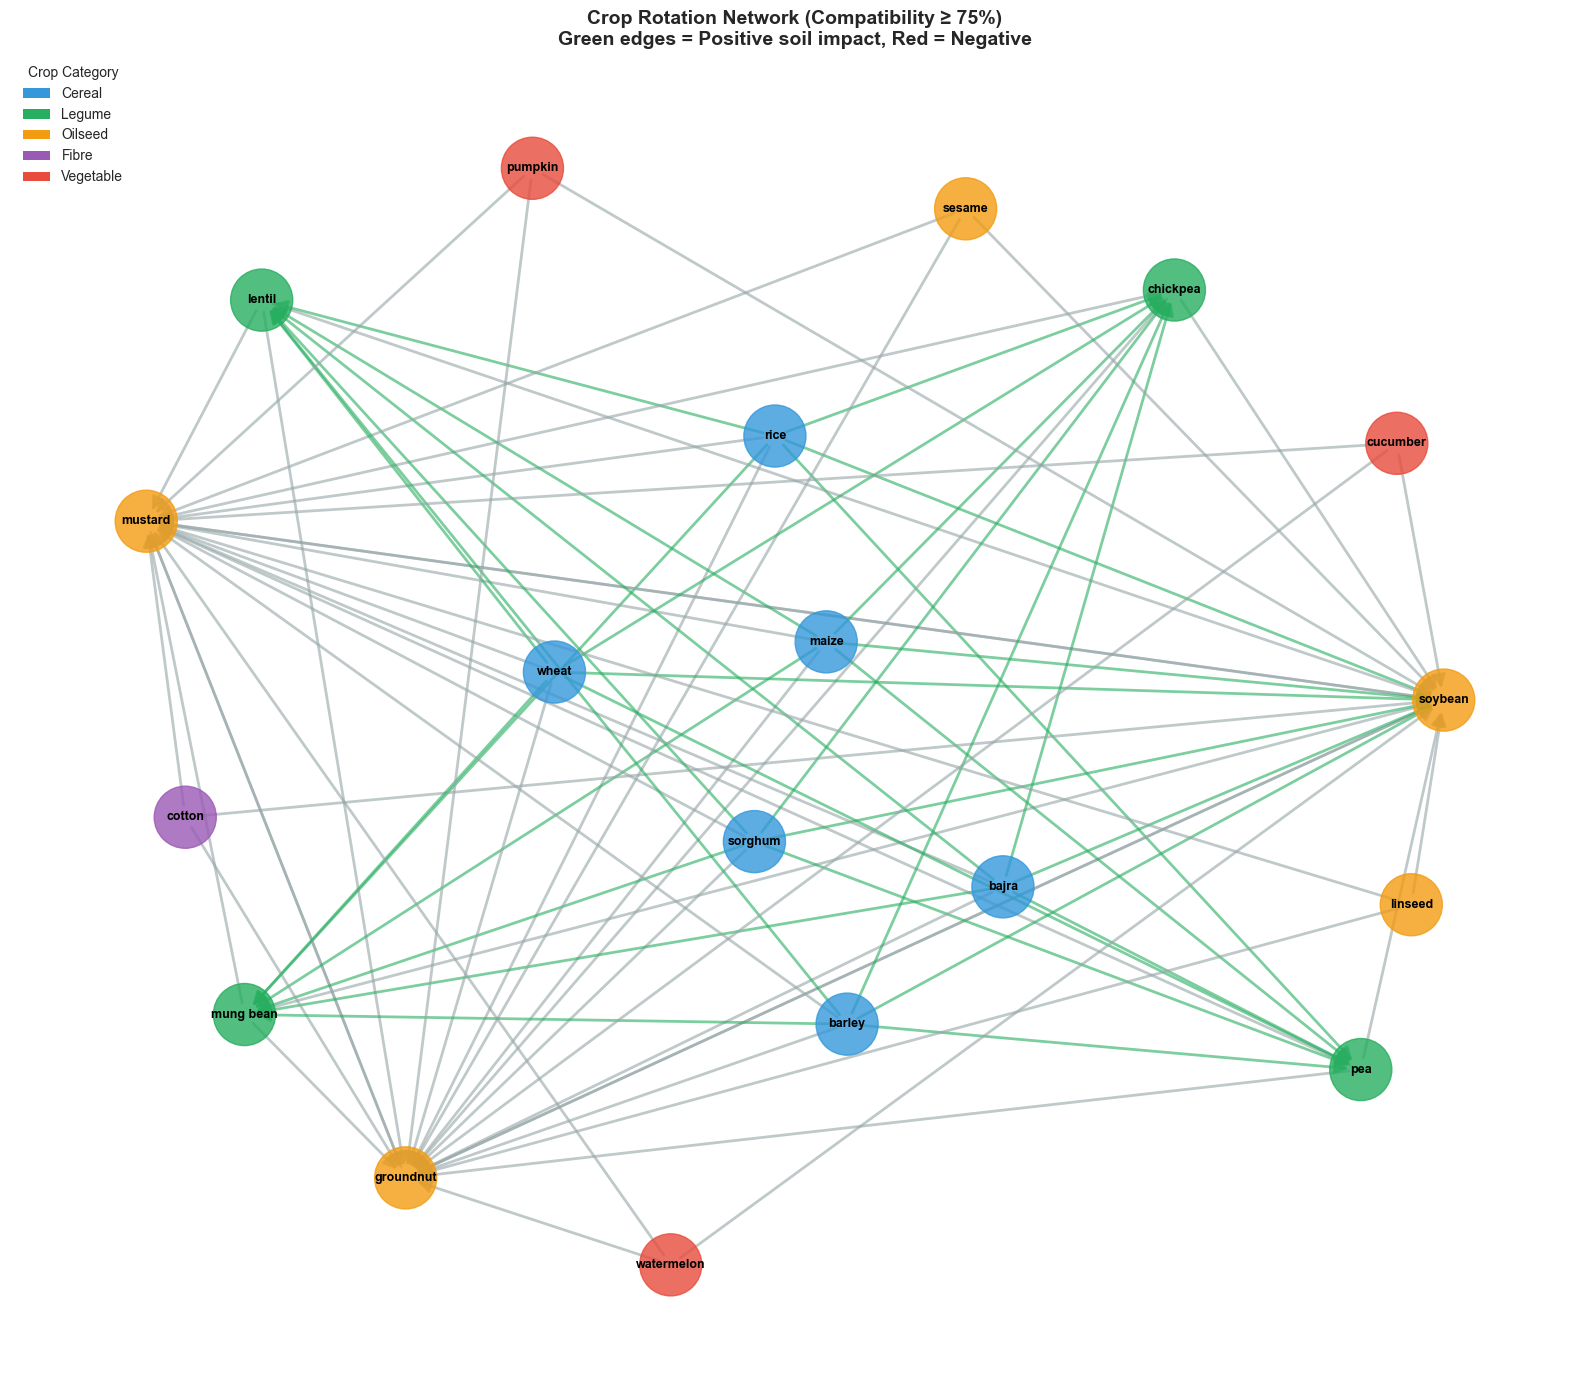

In [32]:
fig,ax=plt.subplots(figsize=(16,14))

node_colors=[]
for node in G.nodes():
    cat=crop_categories.get(node.lower(),'Unknown')
    color_map={
        'Cereal': '#3498db',
        'Legume': '#27ae60',
        'Oilseed': '#f39c12',
        'Fibre': '#9b59b6',
        'Vegetable': '#e74c3c',
        'Unknown': '#95a5a6'
    }
    node_colors.append(color_map.get(cat, '#95a5a6'))
    

edge_colors=[]
for u, v, data in G.edges(data=True):
    impact=data.get('soil_impact', 'Neutral')
    if impact=='Positive':
        edge_colors.append('#27ae60')
    elif impact=='Negative':
        edge_colors.append('#e74c3c')
    else:
        edge_colors.append('#95a5a6')
        
pos=nx.spring_layout(G, k=2, iterations=50,seed=42)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.6, 
                        arrows=True, arrowsize=20, width=2, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Cereal'),
    Patch(facecolor='#27ae60', label='Legume'),
    Patch(facecolor='#f39c12', label='Oilseed'),
    Patch(facecolor='#9b59b6', label='Fibre'),
    Patch(facecolor='#e74c3c', label='Vegetable'),
]
ax.legend(handles=legend_elements, loc='upper left', title='Crop Category')

ax.set_title('Crop Rotation Network (Compatibility ≥ 75%)\nGreen edges = Positive soil impact, Red = Negative', 
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig("../data/visualizations/63_Crop_Rotation_Network.png", dpi=300, bbox_inches='tight')
plt.show()

In [33]:
crops_for_heatmap = list(set(rotation_df['Crop1'].unique()))[:15]

In [34]:
compatibility_matrix = pd.DataFrame(index=crops_for_heatmap, columns=crops_for_heatmap)

In [35]:
for crop1 in crops_for_heatmap:
    for crop2 in crops_for_heatmap:
        if crop1 == crop2:
            compatibility_matrix.loc[crop1, crop2] = 1.0
        else:
            match = rotation_df[
                (rotation_df['Crop1'] == crop1) & 
                (rotation_df['Crop2'] == crop2)
            ]
            if len(match) > 0:
                compatibility_matrix.loc[crop1, crop2] = match['Compatibility_Score'].values[0]
            else:
                compatibility_matrix.loc[crop1, crop2] = 0.5

compatibility_matrix = compatibility_matrix.astype(float)

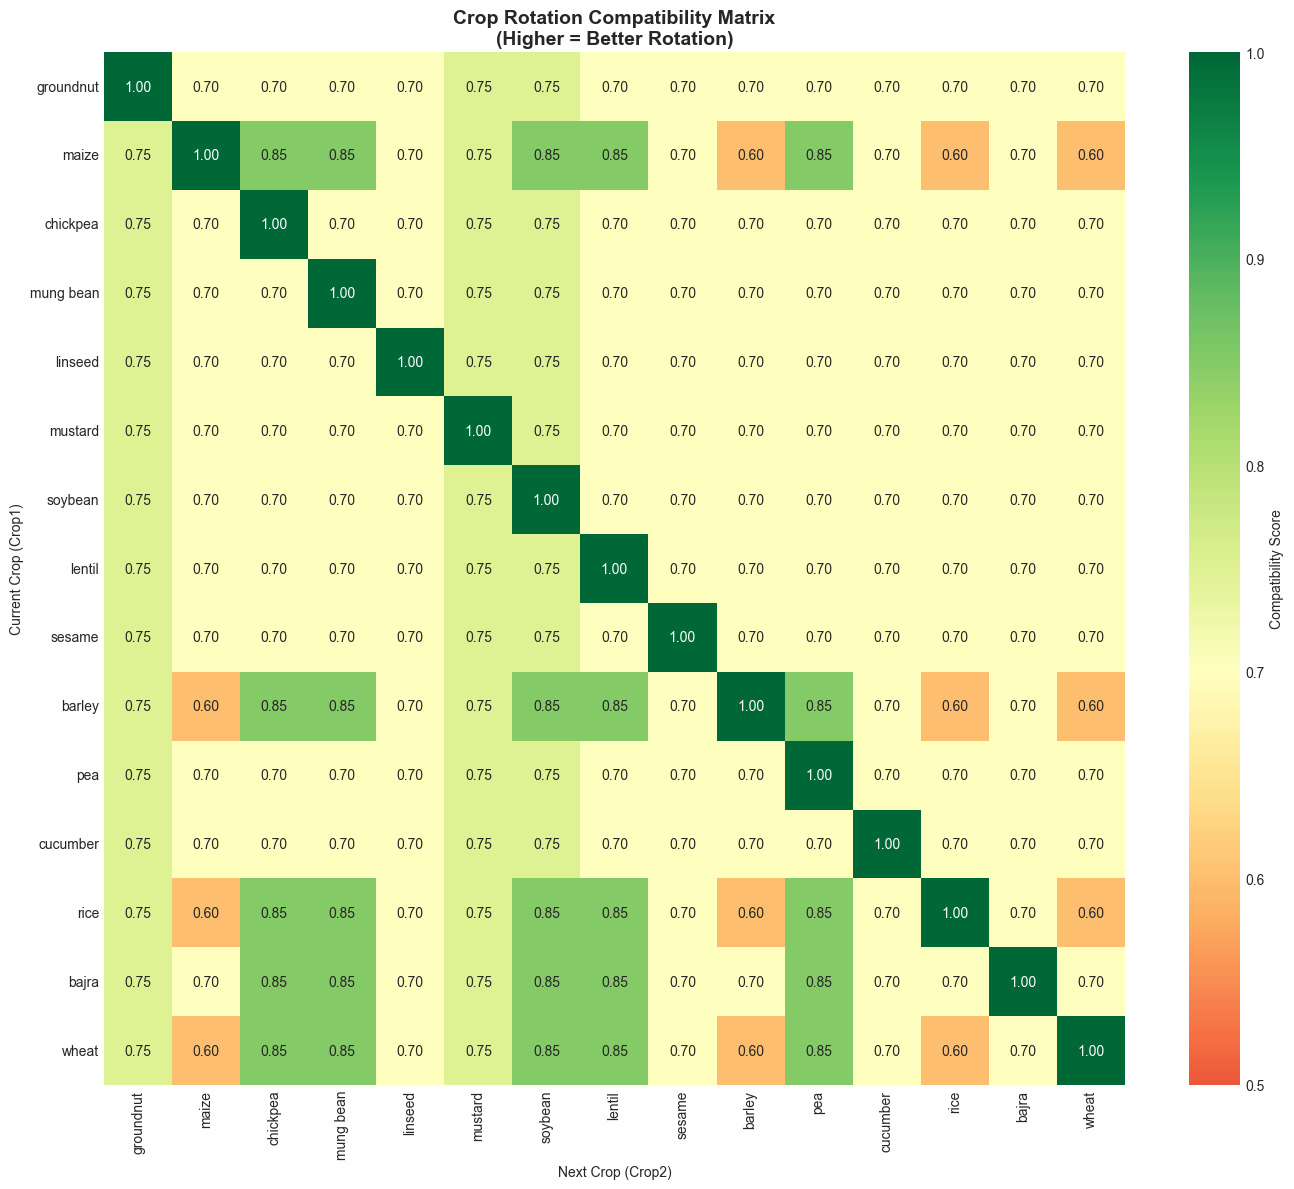

Saved: 64_Crop_Rotation_Heatmap.png


In [36]:
  # Top 15 crops
fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(compatibility_matrix, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0.7, vmin=0.5, vmax=1.0, ax=ax,
            cbar_kws={'label':'Compatibility Score'})

ax.set_title('Crop Rotation Compatibility Matrix\n(Higher = Better Rotation)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Next Crop (Crop2)')
ax.set_ylabel('Current Crop (Crop1)')

plt.tight_layout()
plt.savefig('../data/visualizations/64_Crop_Rotation_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 64_Crop_Rotation_Heatmap.png")

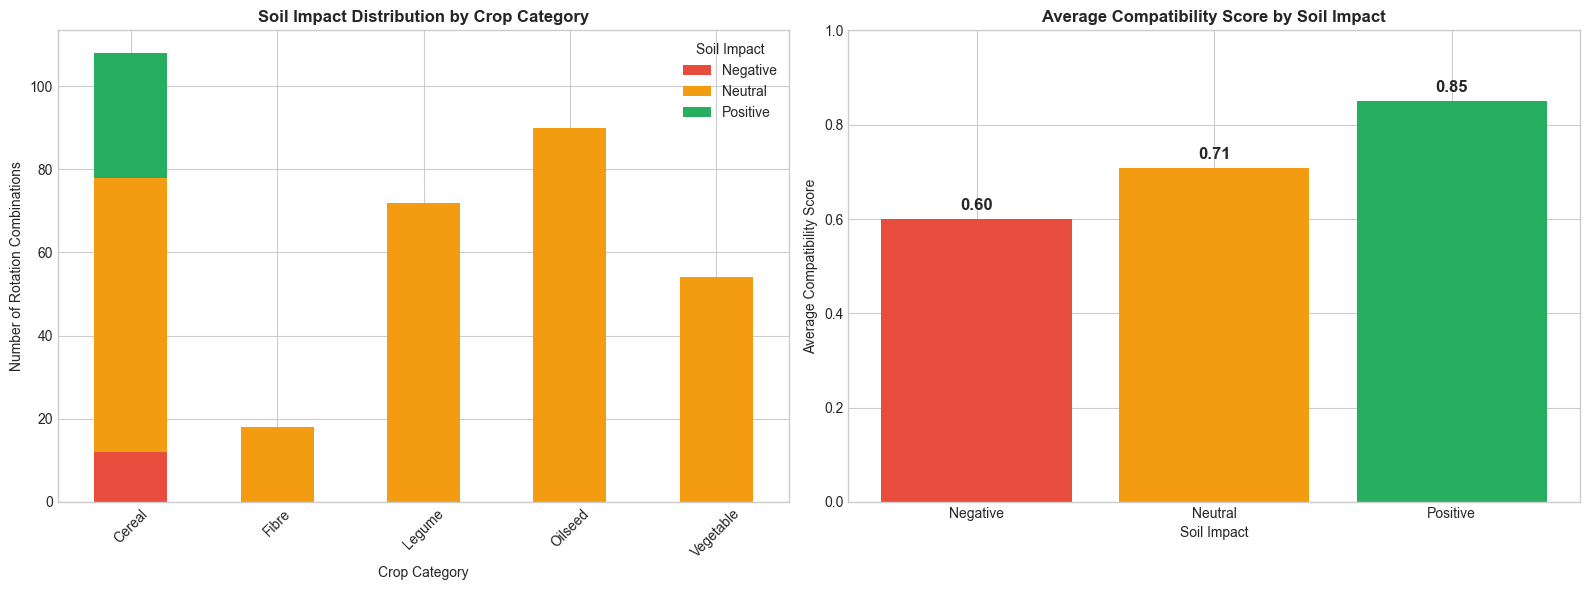

Saved: 65_Rotation_Impact_On_Soil.png


In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Soil impact by crop category
soil_by_category = rotation_df.groupby(['Category1', 'Soil_Impact']).size().unstack(fill_value=0)

soil_by_category.plot(kind='bar', stacked=True, ax=axes[0],
                       color=['#e74c3c', '#f39c12', '#27ae60'])
axes[0].set_title('Soil Impact Distribution by Crop Category', fontweight='bold')
axes[0].set_xlabel('Crop Category')
axes[0].set_ylabel('Number of Rotation Combinations')
axes[0].legend(title='Soil Impact')
axes[0].tick_params(axis='x', rotation=45)

# Compatibility score by soil impact
soil_compat = rotation_df.groupby('Soil_Impact')['Compatibility_Score'].mean()

colors = {'Positive': '#27ae60', 'Neutral': '#f39c12', 'Negative': '#e74c3c'}
bars = axes[1].bar(soil_compat.index, soil_compat.values, 
                    color=[colors[x] for x in soil_compat.index])
axes[1].set_title('Average Compatibility Score by Soil Impact', fontweight='bold')
axes[1].set_xlabel('Soil Impact')
axes[1].set_ylabel('Average Compatibility Score')
axes[1].set_ylim(0, 1)

for bar, val in zip(bars, soil_compat.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.02, 
                 f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/65_Rotation_Impact_On_Soil.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: 65_Rotation_Impact_On_Soil.png")

Visualization-Nutrint Tracking

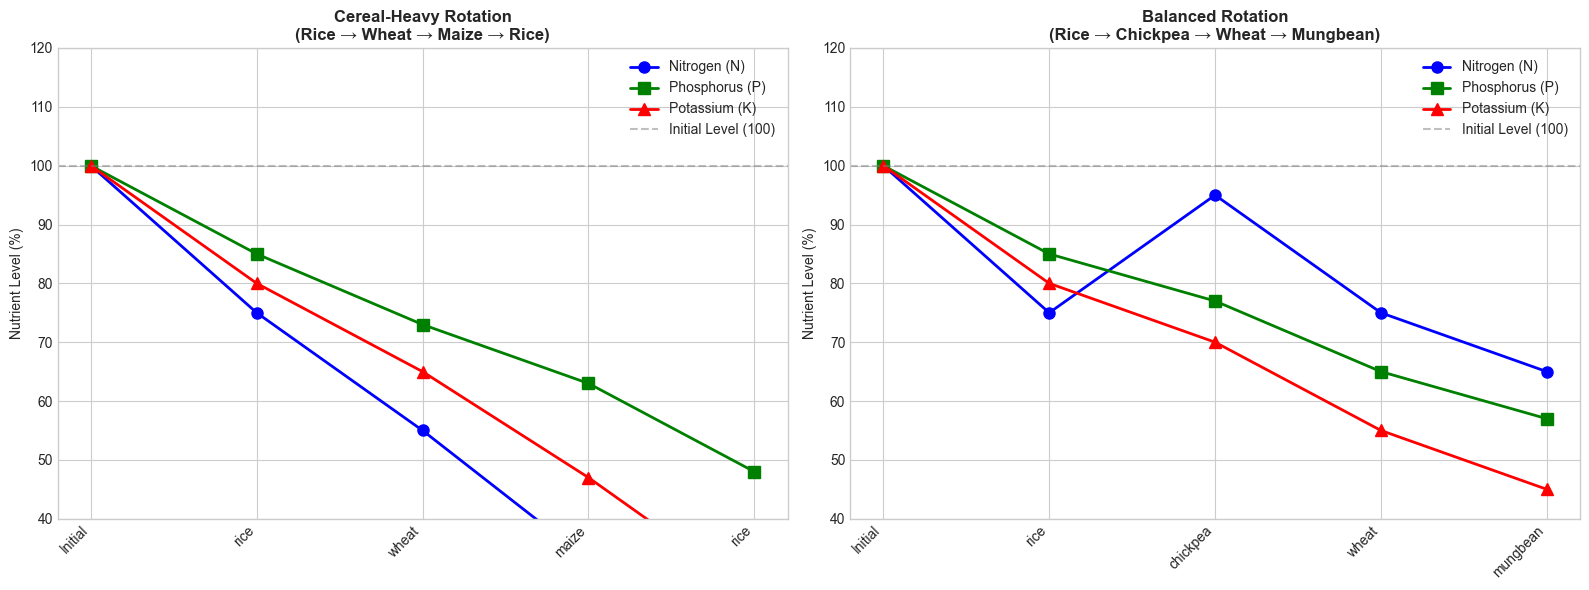

In [38]:
fig,axes=plt.subplots(1,2,figsize=(16,6))

cereal_rotation=["rice","wheat","maize","rice"]
cereal_nutrients=rotation_planner.calculate_soil_nutrients(cereal_rotation)

balanced_rotation=["rice","chickpea","wheat","mungbean"]
balanced_nutrients=rotation_planner.calculate_soil_nutrients(balanced_rotation)


ax1=axes[0]
history1=cereal_nutrients['history']
crop1=[h["crop"] for h in history1]
n_values1=[h["N"] for h in history1]
p_values1=[h["P"] for h in history1]
k_values1=[h["K"] for h in history1]

x=range(len(crop1))
ax1.plot(x,n_values1, 'b-o', label='Nitrogen (N)', linewidth=2, markersize=8)
ax1.plot(x,p_values1, 'g-s', label='Phosphorus (P)', linewidth=2, markersize=8)
ax1.plot(x,k_values1, 'r-^', label='Potassium (K)', linewidth=2, markersize=8)

ax1.axhline(100, color='gray', linestyle='--', label='Initial Level (100)',alpha=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(crop1, rotation=45, fontsize=10,ha='right')
ax1.set_ylabel('Nutrient Level (%)')
ax1.set_title('Cereal-Heavy Rotation\n(Rice → Wheat → Maize → Rice)', fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(40, 120)


#plot 2: balanced rotation
ax2=axes[1]
history2=balanced_nutrients['history']
crop2=[h["crop"] for h in history2]
n_values2=[h["N"] for h in history2]
p_values2=[h["P"] for h in history2]
k_values2=[h["K"] for h in history2]

x=range(len(crop2))
ax2.plot(x,n_values2, 'b-o', label='Nitrogen (N)', linewidth=2, markersize=8)
ax2.plot(x,p_values2, 'g-s', label='Phosphorus (P)', linewidth=2, markersize=8)
ax2.plot(x,k_values2, 'r-^', label='Potassium (K)', linewidth=2, markersize=8)

ax2.axhline(100, color='gray', linestyle='--', label='Initial Level (100)',alpha=0.5)
ax2.set_xticks(x)
ax2.set_xticklabels(crop2, rotation=45, fontsize=10,ha='right')
ax2.set_ylabel('Nutrient Level (%)')
ax2.set_title('Balanced Rotation\n(Rice → Chickpea → Wheat → Mungbean)', fontweight='bold')
ax2.legend(loc='upper right')
ax2.set_ylim(40, 120)

plt.tight_layout()
plt.savefig('../data/visualizations/66_Soil_Nutrient_Tracking.png', dpi=300, bbox_inches='tight')
plt.show()


Sustainability Comparison

In [39]:
rotation_strategies = {
    "Cereal Only": ["rice", "wheat", "maize", "rice"],
    "Legume Focus": ["chickpea", "mungbean", "lentil","pea"],
    "Balanced": ["rice", "chickpea", "wheat", "mungbean"],
    'Oilseed Mix': ['groundnut', 'mustard', 'soybean', 'sesame'],
    'Traditional': ['rice', 'lentil', 'wheat', 'chickpea'],
    'Intensive': ['rice', 'wheat', 'rice', 'wheat']
}

In [40]:
sustainability_data=[]

In [41]:
for strategy_name,crop_sequence in rotation_strategies.items():
    sustainability=rotation_planner.calculate_sustainability_score(crop_sequence)
    nutrients=rotation_planner.calculate_soil_nutrients(crop_sequence)
    
    sustainability_data.append({
        'strategy': strategy_name,
        'crops': '->'.join(crop_sequence),
        'total_score': sustainability['total_score'],
        'rating': sustainability['rating'],
        'diversity': sustainability['components']['diversity'],
        'soil_health': sustainability['components']['soil_health'],
        'compatibility': sustainability['components']['compatibility'],
        'legume': sustainability['components']['legume_inclusion'],
        'n_balance': nutrients['n_balance']
    })

sustainability_df=pd.DataFrame(sustainability_data)

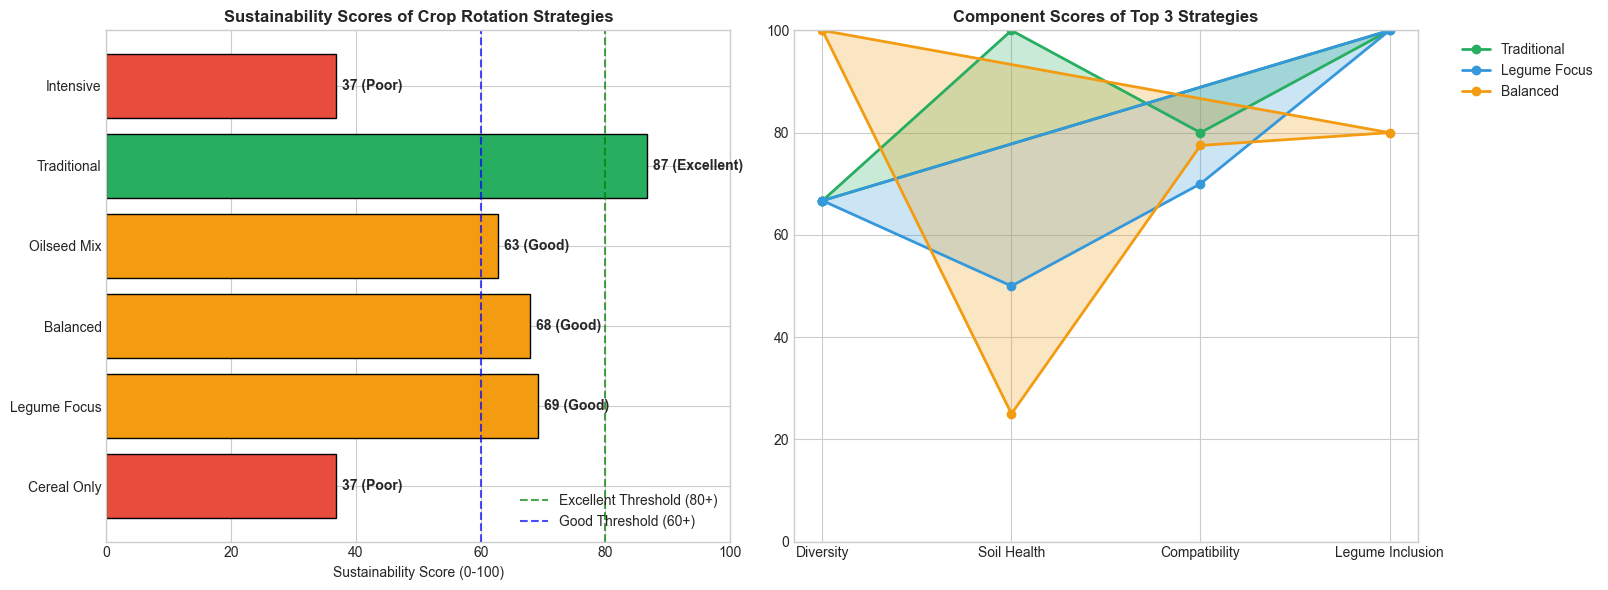

In [43]:
fig,axes=plt.subplots(1,2,figsize=(16,6))

ax1=axes[0]
colors=[]
for rating in sustainability_df['rating']:
    if rating=='Excellent':
        colors.append('#27ae60')
    elif rating=='Good':
        colors.append('#f39c12')
    elif rating=='Fair':
        colors.append('#e67e22')
    else:
        colors.append('#e74c3c')
        
bars=ax1.barh(sustainability_df['strategy'], sustainability_df['total_score'], color=colors,edgecolor="black")

ax1.axvline(x=80,color="green",linestyle="--",label="Excellent Threshold (80+)",alpha=0.7)
ax1.axvline(x=60,color="blue",linestyle="--",label="Good Threshold (60+)",alpha=0.7)


for bar,score,rating in zip(bars,sustainability_df["total_score"],sustainability_df["rating"]):
    ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,f'{score:.0f} ({rating})', va='center', fontsize=10, fontweight='bold')

ax1.set_xlabel('Sustainability Score (0-100)')
ax1.set_title('Sustainability Scores of Crop Rotation Strategies', fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xlim(0, 100)

# Radar chart of components
ax2=axes[1]
categories=['Diversity','Soil Health','Compatibility','Legume Inclusion']
num_vars=len(categories)

top_3=sustainability_df.nlargest(3,'total_score')

angles=[n/float(num_vars)*2*np.pi for n in range(num_vars)]
angles+=angles[:1]

colors_radar = ['#27ae60', '#3498db', '#f39c12']

for idx,(_,row) in enumerate(top_3.iterrows()):
    values=[row['diversity'], row['soil_health'], row['compatibility'], row['legume']]
    values+=values[:1]
    
    ax2.plot(angles,values,'o-',linewidth=2,label=row['strategy'],color=colors_radar[idx])
    ax2.fill(angles,values,alpha=0.25,color=colors_radar[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right',bbox_to_anchor=(1.3, 1))
ax2.set_title('Component Scores of Top 3 Strategies', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/67_Rotation_Strategy_Sustainability.png', dpi=300, bbox_inches='tight')
plt.show()

Season Flow Diagram

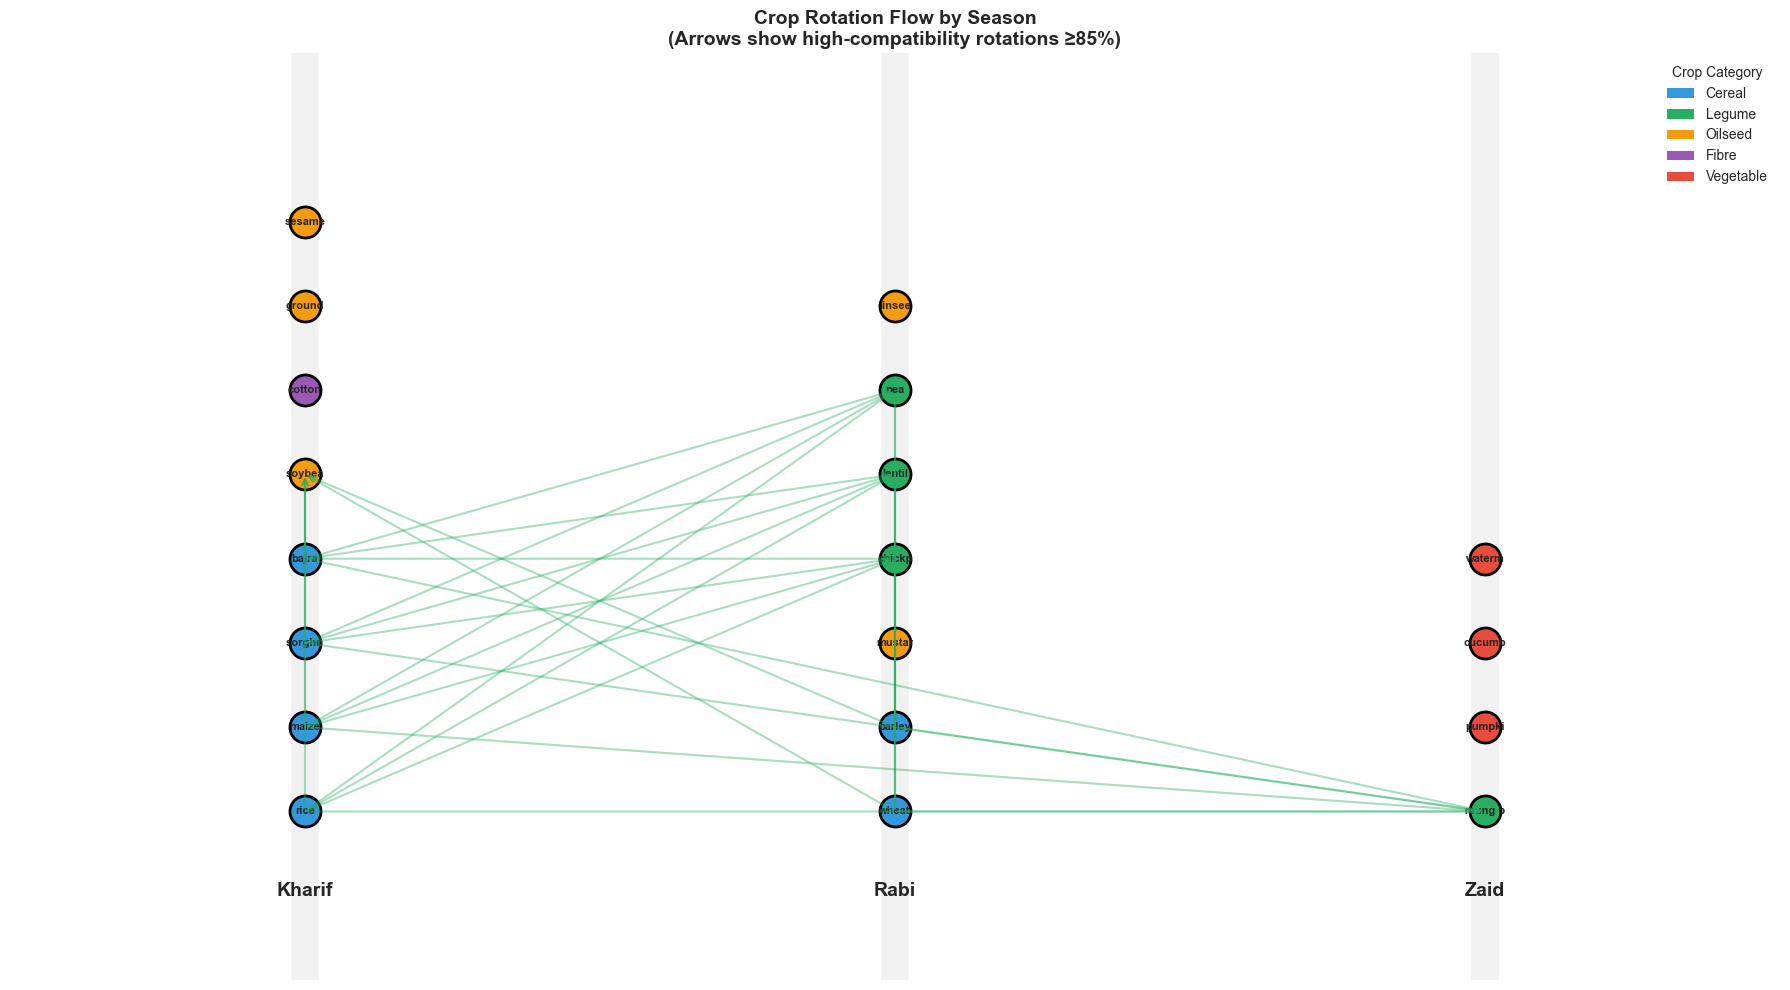

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
seasons = ['Kharif', 'Rabi', 'Zaid']
season_positions = {
    'Kharif': 0,
    'Rabi': 1,
    'Zaid': 2
}

# Get unique crops by season
season_crops = {}
for season in seasons:
    crops = rotation_df[rotation_df['Season1'] == season]['Crop1'].unique()
    season_crops[season] = list(crops)

# Define vertical positions for crops
y_positions = {}
for season in seasons:
    crops = season_crops[season]
    for i, crop in enumerate(crops):
        y_positions[(crop, season)] = i

# Draw season columns
for i, season in enumerate(seasons):
    ax.axvline(x=i, color='lightgray', linestyle='-', linewidth=20, alpha=0.3)
    ax.text(i, -1, season, fontsize=14, fontweight='bold', ha='center')

# Draw crops as nodes
for season in seasons:
    x = season_positions[season]
    for crop in season_crops[season]:
        y = y_positions[(crop, season)]
        
        cat = crop_categories.get(crop.lower(), 'Unknown')
        color_map = {
            'Cereal': '#3498db',
            'Legume': '#27ae60',
            'Oilseed': '#f39c12',
            'Fibre': '#9b59b6',
            'Vegetable': '#e74c3c',
            'Unknown': '#95a5a6'
        }
        color = color_map.get(cat, '#95a5a6')
        
        ax.scatter(x, y, s=500, c=color, edgecolors='black', linewidth=2, zorder=3)
        ax.text(x, y, crop[:6], fontsize=8, ha='center', va='center', fontweight='bold')

high_compat = rotation_df[rotation_df['Compatibility_Score'] >= 0.85]

for _, row in high_compat.iterrows():
    crop1 = row['Crop1']
    crop2 = row['Crop2']
    season1 = row['Season1']
    season2 = row['Season2']
    
    if (crop1, season1) in y_positions and (crop2, season2) in y_positions:
        x1 = season_positions[season1]
        y1 = y_positions[(crop1, season1)]
        x2 = season_positions[season2]
        y2 = y_positions[(crop2, season2)]
        
        color = '#27ae60' if row['Soil_Impact'] == 'Positive' else '#f39c12'
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', color=color, alpha=0.4, lw=1.5))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(-2, max(len(v) for v in season_crops.values()) + 1)
ax.axis('off')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='Cereal'),
    Patch(facecolor='#27ae60', label='Legume'),
    Patch(facecolor='#f39c12', label='Oilseed'),
    Patch(facecolor='#9b59b6', label='Fibre'),
    Patch(facecolor='#e74c3c', label='Vegetable'),
]
ax.legend(handles=legend_elements, loc='upper right', title='Crop Category')

ax.set_title('Crop Rotation Flow by Season\n(Arrows show high-compatibility rotations ≥85%)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/visualizations/68_Rotation_Flow_By_Season.png', dpi=300, bbox_inches='tight')
plt.show()

Export

In [46]:
rotation_df.to_csv("../data/processed/rotation_rules_processed.csv", index=False)
print("Saved: rotation_rules_processed.csv")

sustainability_df.to_csv("../data/results/rotation_sustainability_comparison.csv", index=False)
print("Saved: rotation_sustainability_comparison.csv")

sample_plans = []
for crop, season in [('rice', 'Kharif'), ('wheat', 'Rabi'), ('cotton', 'Kharif'), 
                     ('chickpea', 'Rabi'), ('maize', 'Kharif')]:
    plan = rotation_planner.get_rotation_plan(crop, season, num_seasons=4)
    
    sample_plans.append({
        'starting_crop': crop,
        'starting_season': season,
        'rotation_sequence': ' → '.join([p['crop'] for p in plan['plan']]),
        'sustainability_score': plan['sustainability']['total_score'],
        'rating': plan['sustainability']['rating'],
        'n_balance': plan['nutrients']['n_balance'],
        'p_balance': plan['nutrients']['p_balance'],
        'k_balance': plan['nutrients']['k_balance']
    })

sample_plans_df = pd.DataFrame(sample_plans)
sample_plans_df.to_csv("../data/results/sample_rotation_plans.csv", index=False)
print("Saved: sample_rotation_plans.csv")

compatibility_matrix.to_csv("../data/results/compatibility_matrix.csv")
print("Saved: compatibility_matrix.csv")

rotation_summary = {
    'total_rotation_combinations': len(rotation_df),
    'unique_crops': len(all_crops),
    'seasons': list(seasons),
    'avg_compatibility': round(rotation_df['Compatibility_Score'].mean(), 3),
    'high_compatibility_count': len(rotation_df[rotation_df['Compatibility_Score'] >= 0.8]),
    'positive_soil_impact_count': len(rotation_df[rotation_df['Soil_Impact'] == 'Positive']),
    'neutral_soil_impact_count': len(rotation_df[rotation_df['Soil_Impact'] == 'Neutral']),
    'negative_soil_impact_count': len(rotation_df[rotation_df['Soil_Impact'] == 'Negative']),
    'best_rotation_strategy': sustainability_df.loc[sustainability_df['total_score'].idxmax(), 'strategy'],
    'best_strategy_score': sustainability_df['total_score'].max()
}

pd.DataFrame([rotation_summary]).to_csv("../data/results/rotation_summary.csv", index=False)
print("Saved: rotation_summary.csv")


Saved: rotation_rules_processed.csv
Saved: rotation_sustainability_comparison.csv
Saved: sample_rotation_plans.csv
Saved: compatibility_matrix.csv
Saved: rotation_summary.csv


Save Rotation Planner For Flask Integration

In [47]:
with open('../models/rotation_planner.pkl', 'wb') as f:
    pickle.dump(rotation_planner, f)
print("Saved: rotation_planner.pkl")

Saved: rotation_planner.pkl


In [48]:
rotation_support_data = {
    'crop_categories': crop_categories,
    'crop_nutrient_data': crop_nutrient_data,
    'nitrogen_impact': nitrogen_impact,
    'season_sequence': season_sequence,
    'season_calendar': season_calendar
}

In [49]:
with open('../models/rotation_support_data.pkl', 'wb') as f:
    pickle.dump(rotation_support_data, f)
print("Saved: rotation_support_data.pkl")

Saved: rotation_support_data.pkl


In [52]:
flask_rotation_code = '''
"""
Crop Rotation Planning Module for Flask Web Application
"""

import pickle
import os

# Paths
MODELS_PATH = os.path.join(os.path.dirname(__file__), '..', 'models')

# Load rotation planner
def load_rotation_planner():
    """Load the saved rotation planner"""
    try:
        planner_path = os.path.join(MODELS_PATH, 'rotation_planner.pkl')
        with open(planner_path, 'rb') as f:
            planner = pickle.load(f)
        return planner
    except FileNotFoundError:
        print("⚠️ Rotation planner not found. Please run Notebook 15 first.")
        return None

# Global planner instance
ROTATION_PLANNER = load_rotation_planner()


def get_rotation_suggestions(current_crop, current_season, num_seasons=3):
    """
    Get rotation suggestions for a given crop and season
    
    Parameters:
    -----------
    current_crop : str
        Current crop name
    current_season : str
        Current season (Kharif, Rabi, Zaid)
    num_seasons : int
        Number of seasons to plan
        
    Returns:
    --------
    dict : Rotation plan with sustainability scores
    """
    if ROTATION_PLANNER is None:
        return {'error': 'Rotation planner not loaded'}
    
    try:
        plan = ROTATION_PLANNER.get_rotation_plan(
            current_crop=current_crop,
            current_season=current_season,
            num_seasons=num_seasons
        )
        return plan
    except Exception as e:
        return {'error': str(e)}


def get_best_successor(current_crop, target_season=None):
    """
    Get the best successor crop
    
    Parameters:
    -----------
    current_crop : str
        Current crop
    target_season : str, optional
        Target season
        
    Returns:
    --------
    dict : Best successor details
    """
    if ROTATION_PLANNER is None:
        return {'error': 'Rotation planner not loaded'}
    
    return ROTATION_PLANNER.get_best_successor(current_crop, target_season)


def get_alternative_plans(current_crop, current_season, num_alternatives=3):
    """
    Get alternative rotation plans
    
    Parameters:
    -----------
    current_crop : str
        Current crop
    current_season : str
        Current season
    num_alternatives : int
        Number of alternatives
        
    Returns:
    --------
    list : Alternative rotation plans
    """
    if ROTATION_PLANNER is None:
        return {'error': 'Rotation planner not loaded'}
    
    return ROTATION_PLANNER.get_alternative_plans(
        current_crop, current_season, num_alternatives
    )


def calculate_sustainability(crop_sequence):
    """
    Calculate sustainability score for a crop sequence
    
    Parameters:
    -----------
    crop_sequence : list
        List of crops
        
    Returns:
    --------
    dict : Sustainability scores
    """
    if ROTATION_PLANNER is None:
        return {'error': 'Rotation planner not loaded'}
    
    return ROTATION_PLANNER.calculate_sustainability_score(crop_sequence)


def track_nutrients(crop_sequence):
    """
    Track soil nutrients for a crop sequence
    
    Parameters:
    -----------
    crop_sequence : list
        List of crops
        
    Returns:
    --------
    dict : Nutrient tracking data
    """
    if ROTATION_PLANNER is None:
        return {'error': 'Rotation planner not loaded'}
    
    return ROTATION_PLANNER.calculate_soil_nutrients(crop_sequence)


def generate_report(current_crop, current_season, num_seasons=3):
    """
    Generate a detailed rotation report
    
    Parameters:
    -----------
    current_crop : str
        Current crop
    current_season : str
        Current season
    num_seasons : int
        Number of seasons
        
    Returns:
    --------
    str : Formatted report
    """
    if ROTATION_PLANNER is None:
        return 'Rotation planner not loaded'
    
    plan = ROTATION_PLANNER.get_rotation_plan(current_crop, current_season, num_seasons)
    return ROTATION_PLANNER.generate_rotation_report(plan)
'''

# Save the Flask module
webapp_path = '../webapp/'
os.makedirs(webapp_path, exist_ok=True)

with open(webapp_path + 'rotation.py', 'w', encoding='utf-8') as f:
    f.write(flask_rotation_code)

print(f"✅ Saved: webapp/rotation.py")

✅ Saved: webapp/rotation.py
